**Nom du / des étudiant(s)** : ETUDIANT 1 - ETUDIANT 2

# TP image - filtrage

Dans ce TP, quelques images sont fournies, mais vous êtes fortement encouragés à récupérer et expérimenter sur d'autres images récupérées sur le web.

Les TP de traitement d'images sont réalisés en Python3, à l'aide de la librairie [scikit-image](http://scikit-image.org/docs/stable/). Les tableaux utilisés  (`ndarray`) par cette librairie pour manipuler les images proviennent de la librairie [numpy](https://docs.scipy.org/doc/). L'affichage des images et autres figures est réalisé grace à [matplotlib](https://matplotlib.org/contents.html). La documentation de ces trois librairies vous sera donc bien utile.

Dans ce TP, les questions seront indiquées dans un bloc **question**, et les réponses seront à donner dans le bloc **réponse**  situé en dessous du bloc de question. Vos réponses sont à rédiger en [markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). Vous pourrez ainsi répondre non seulement avec du texte, mais aussi avec des tableaux et des images.

Ce TP est à réaliser en deux séances d'1h30.

**Remarque importante:** Les questions posées dans ce TP requièrent généralement des <u>réponses courtes mais justifées</u>. Un simple oui ou non ne nous est d'aucune utilité pour juger de votre compréhension de la question et de sa réponse...

**Autre remarque:** Il y a parfois plusieurs sous-questions dans une même question. <u>Pensez a répondre à toutes les sous-questions</u>.


In [2]:
%matplotlib inline
# la ligne précédente permet d'afficher les figures directement dans votre notebook
# si vous voulez des figures interactives et n'êtes PAS dans un notebook cocalc vous pouvez utiliser widget à la place d'inline

# On importe tous les modules dont nous aurons besoin pour ce TP
import numpy as np  # pour les ndarray (donc les tableaux / matrices) et les convolutions
import scipy as sp  # pour la déconvolution
import matplotlib.pyplot as plt # gestion des figures

from scipy import signal
from skimage import io,data,color # on charge le module permettant d'ouvrir des images


## La convolution en dimension 1 sur des petits exemples 

**Question 1:** 
- Faire le calcul de convolution $[1, 1, 1]*[1, 1, 1]$ à la main pour vérifier que ça donne bien ce que trouve la machine (donnez les détails du calcul dans la case réponse). 
- Ce filtre est-il **linéaire** ?

**Réponse 1**: On place notre signal de base sur un graphe puis on le glisse en faisant la convolution. $[1*1 + 1*0 + 1*0 , 1*1 + 1*1 + 1*0, 1*1 + 1*1 + 1*1, 1*0 + 1*1 + 1*1, 1*0 + 1*0 + 1*1]$

Cette convolution nécessite de traiter un problème pas très intéressant mais inévitable : que fait-on quand le calcul de convolution fait appel à des valeurs du signal "hors de ses bornes", c.a.d. avant son début ou après sa fin ? On rencontrera le même problème en image, hors des bords de l'image. La fonction 'convolve' de scipy suppose que le signal vaut 0 hors de son domaine de définition, mais elle permet de choisir de donner (option 'full') ou pas (option 'valid') les résultats selon qu'ils font appel à des 0 introduits artificiellement sur les bords. L'option 'same' est un intermédiaire qui renvoie un résultat de même taille que le vecteur d'entrée. Les diverses manières de traiter cette question (qui n'est *pas* centrale au TP) amènent à des longueurs de vecteurs résultats qui diffèrent selon l'option choisie.

In [3]:
a = np.array([1, 1, 1])
c = np.convolve(a,a,'full')
print(c)
c = np.convolve(a,a,'same')
print(c)
c = np.convolve(a,a,'valid')
print(c)

[1 2 3 2 1]
[2 3 2]
[3]


Le vecteur `[1, 1, 1]` est souvent nommé "filtre **moyenneur**". En toute rigueur, il faudrait utiliser le filtre $\frac{1}{3}$`[1, 1, 1]` qui, convolué avec un signal, calcule une moyenne glissante sur ce signal. Examinons l'effet de la convolution d'un tel filtre avec  convolution d'une forte **discontinuité** par un filtre [1 1 1]. Notons qu'on utilise ici le mode "same" de la convolution pour obtenir un signal de sortie de même longueur que celui d'entrée.

[ 0  0  0  0  0 10 20 30 30 30 30 20]


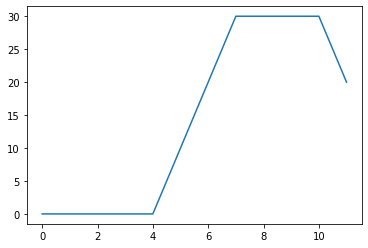

In [4]:
marche_escalier = np.array([0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10])
escalier_lisse = np.convolve(marche_escalier, a, mode='same')
print(escalier_lisse)
plt.plot(escalier_lisse)

### Associativité

**Question 2:** Est-ce que (a$*$a)$*$marche_escalier = a$*$(a$*$marche_escalier) ?

**Réponse 2:** Oui car le produit de convolution est associatif

In [5]:
print( np.convolve(escalier_lisse, a, mode='same') )
print( np.convolve(marche_escalier,c, mode='same') )

[ 0  0  0  0 10 30 60 80 90 90 80 50]
[ 0  0  0  0  0  0 30 30 30 30 30 30]


**Question 3:** Quel intérêt à cette propriété, si on considère l'application successive de deux convolutions à un signal ?

**Réponse 3:** On peut appliquer les convolutions sans se soucier de l'ordre d'applicaiton.

### Commutativité
On vérifie que a$*$marche_escalier=marche_escalier$*$a

In [6]:
print( np.convolve (marche_escalier, a))
print( np.convolve (a, marche_escalier))

[ 0  0  0  0  0  0 10 20 30 30 30 30 20 10]
[ 0  0  0  0  0  0 10 20 30 30 30 30 20 10]


De la commutativité,

**Question 4:**
* que conclure quant aux rôles de "filtre" et de "signal" quand on filtre un signal ?
* que conclure quant à l'ordre dans lequel on applique deux filtrages successifs sur un signal ?

**Réponse 4:** Il n'y a pas vraiment de role vu que le produit de convolution est associatif et commutatif, par conséquent on peut appliquer les filtres dans n'importe quel ordre.

### Déconvolution

L'opération de convolution ci-dessus peut être **réversible**, en particulier si on connait l'un des deux termes de la convolution. On se contentera de considérer cette fonction de déconvolution comme une boite noire. On reviendra, à la fin du TP, sur le cas 
où on ne connait aucun des deux termes de la convolution, dont la résolution est généralement complexe et approximative, mais riche d'applications.

In [7]:
escalier_deconvolue, e = sp.signal.deconvolve(escalier_lisse,a)
print(escalier_deconvolue)


[ 0.  0.  0.  0.  0. 10. 10. 10. 10. 10.]


Un point intéressant mais que nous ne traiterons que superficiellement ici : si on répète souvent la convolution d'un vecteur quelconque par `[1.0 1.0 1.0]`, le résultat tend vers une gaussienne. On peut aller cherche une explication du coté du [théorème central limite](https://fr.wikipedia.org/wiki/Théorème_central_limite).

Text(0.5, 1.0, 'Après convolutions multiples')

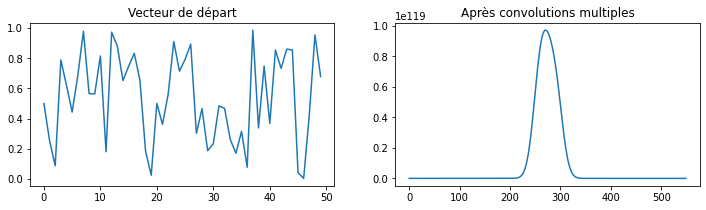

In [8]:
a = np.random.rand(50) # vecteur aléatoire de taille 50
b = np.copy(a)
for x in range(250):
    b = np.convolve(b,[1.0, 1.0, 1.0])

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(a)
plt.title("Vecteur de départ")
plt.subplot(122)
plt.plot(b)
plt.title("Après convolutions multiples")

## Toujours des petits exemples, mais en dimension 2

* Vérifier ci-dessous qu'on peut construire un filter bi-dimensionnel en convoluant un filtre horizontal avec un filtre vertical
* Observer le résultat de la convolution du filtre bidimensionnel ainsi créé avec lui-même 

In [9]:
a = np.array([[1, 1, 1]])
print("a=",a)
b = np.transpose(a)
print("b=",b)
c = sp.signal.convolve2d(a,b)
print("c=",c)
d= sp.signal.convolve2d(c,c)
print("d=",d)
e= sp.signal.convolve2d(d,c)
print("e=",e)

a= [[1 1 1]]
b= [[1]
 [1]
 [1]]
c= [[1 1 1]
 [1 1 1]
 [1 1 1]]
d= [[1 2 3 2 1]
 [2 4 6 4 2]
 [3 6 9 6 3]
 [2 4 6 4 2]
 [1 2 3 2 1]]
e= [[ 1  3  6  7  6  3  1]
 [ 3  9 18 21 18  9  3]
 [ 6 18 36 42 36 18  6]
 [ 7 21 42 49 42 21  7]
 [ 6 18 36 42 36 18  6]
 [ 3  9 18 21 18  9  3]
 [ 1  3  6  7  6  3  1]]


Remarquer que si on continuait à convoluer le résultat avec `c`, on tendrait vers un filtre gaussien. Ci-dessous, affichons une distribution gaussienne pour s'en rappeller l'allure. Le point de vue 3D est modifiable à la souris sur la figure.

Text(0.5, 0.92, 'Exemple de filtre gaussien bidimensionnel')

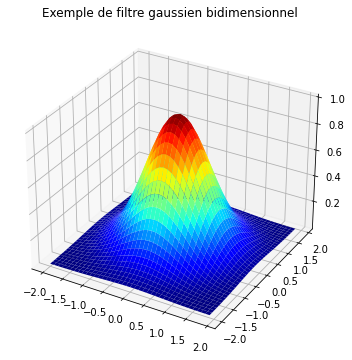

In [10]:
xgv = np.arange(-2, 2, 0.1)
ygv = np.arange(-2, 2, 0.1)
[X,Y] = np.meshgrid(xgv, ygv)
V = np.exp(-(X**2 + Y**2))  #On ne met pas le terme de normalisation car c'est juste pour voir la forme de la fonction
 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, V, rstride=1, cstride=1, cmap=plt.cm.jet, linewidth=0.3)
plt.title('Exemple de filtre gaussien bidimensionnel')

## Filtrage gaussien

On évalue maintenant la capacité du filtrage gaussien à réduire le bruit dans une image. Cette évaluation sera faite en terme de qualité d'image perçue.
* l'image `noisy1` subit un bruit de type "poivre et sel" (non additif)
* l'image `noisy2` subit un bruit gaussien (! ça n'a rien à voir avec le filtrage gaussien ! )


Rapport signal / bruit de l'image 1 bruitée: 2.83 db
Rapport signal / bruit de l'image 1 débruitée: 9.89 db


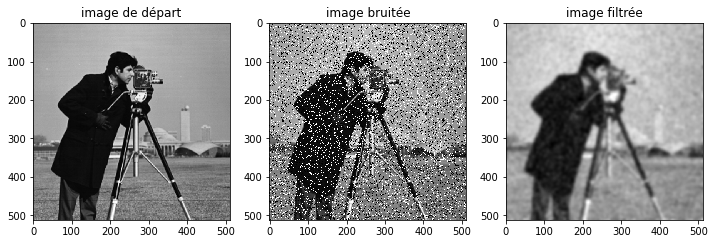

In [19]:
# Maniupulations de noisy1 avec du bruit poivre et sel
from skimage import util,filters
import math

im = data.camera()
seuil = 0.1

def add_salt_and_pepper_noise(clean_image, seuil):
    noise = np.random.random(clean_image.shape)
    noisy_image=clean_image.copy()
    noisy_image[noise > 1-seuil] = 255
    noisy_image[noise < seuil] = 0
    return(noisy_image)


filtered = filters.gaussian(im, sigma =4)

plt.figure(figsize=(12,12))
noisy1=add_salt_and_pepper_noise(im, seuil)
filtered1 = filters.gaussian(noisy1, sigma =4)
noise1 = noisy1-im
noise_after_filter1=filtered1-filtered

plt.subplot(131)
plt.imshow(im, cmap='gray',interpolation='nearest')
plt.title("image de départ")
plt.subplot(132)
plt.imshow(noisy1, cmap='gray',interpolation='nearest')
plt.title("image bruitée")
plt.subplot(133)
plt.imshow(filtered1, cmap='gray',interpolation='nearest')
plt.title("image filtrée")

print("Rapport signal / bruit de l'image 1 bruitée: {:.2f} db".format(10*math.log10(im.mean()/noise1.std())))
print("Rapport signal / bruit de l'image 1 débruitée: {:.2f} db".format(10*math.log10(filtered1.mean()/noise_after_filter1.std())))

Ecart type du bruit gaussien: 25.4709
Ecart type du bruit gaussien filtré: 1.8078
Rapport signal / bruit de l'image bruitée: 6.67 db
Rapport signal / bruit de l'image débruitée: 18.16 db


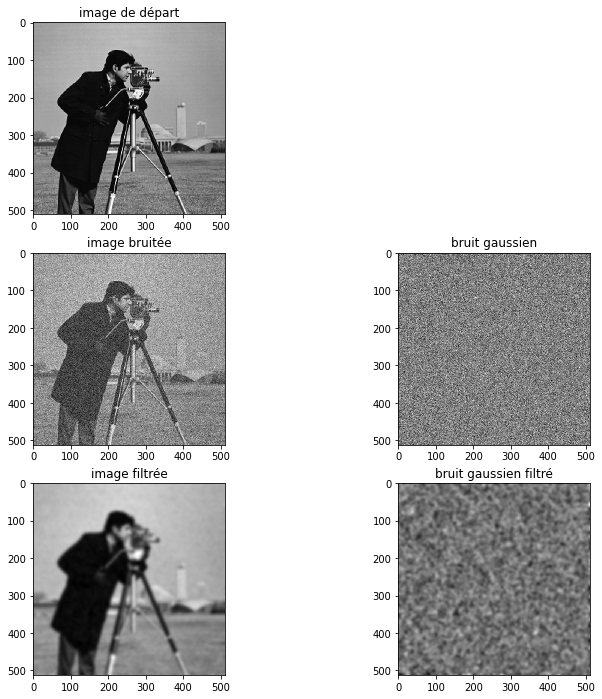

In [20]:
# Maniupulations de noisy2 avec du bruit gaussien 
import math

noise_std = 0.1

noise2 = np.random.normal(loc=0.0, scale=noise_std, size=im.shape)*255
noisy2 = im.copy() + noise2
noisy2.clip(0,255)
filterednoise2 = filters.gaussian(noise2, sigma = 4)
filtered2 = filters.gaussian(noisy2, sigma = 4)

plt.figure(figsize=(12,12))
plt.subplot(321)
plt.imshow(im, cmap='gray',interpolation='nearest')
plt.title("image de départ")
plt.subplot(323)
plt.imshow(noisy2, cmap='gray',interpolation='nearest')
plt.title("image bruitée")
plt.subplot(324)
plt.imshow(noise2, cmap='gray',interpolation='nearest')
plt.title("bruit gaussien")
plt.subplot(325)
plt.imshow(filtered2, cmap='gray',interpolation='nearest')
plt.title("image filtrée")
plt.subplot(326)
plt.imshow(filterednoise2, cmap='gray',interpolation='nearest')
plt.title("bruit gaussien filtré")


print("Ecart type du bruit gaussien: {:.4f}".format(np.std(noise2)))
print("Ecart type du bruit gaussien filtré: {:.4f}".format(np.std(filterednoise2)))
print("Rapport signal / bruit de l'image bruitée: {:.2f} db".format(10*math.log10(im.mean()/noise2.std())))
print("Rapport signal / bruit de l'image débruitée: {:.2f} db".format(10*math.log10(filtered2.mean()/filterednoise2.std())))


**Question 5:**
* Expérimentez avec diverses valeur de `seuil`, probabilité d'avoir du bruit poivre et sel, et `noise_std`, écart-type du filtre gaussien, pour en évaluer l'effet sur la préservation de l'image et l'atténuation du bruit. Commentez ensuite vos résultats. 
* Quels sont les types d'éléments de l'image qui souffrent le plus du filtrage gaussien ? 
* Le filtrage gaussien vous semble-t-il aussi efficace sur les deux types de bruit ?


**Réponse 5:** En appliquant un filtre gaussin sur l'image, cela diminue le bruit, mais l'image perd en information, autrement dit elle se floute. Pour le poivre et sel, le bruit est diminué mais toujours visible, l'image se floute également. Le filtre gaussien semble plus efficace sur le bruit gaussien.

**Question 6:** Concernant le bruit gaussien, en considérant que le bruit est additif c.a.d. que $Image_{bruitee}=Image_{originale}+Image_{bruit}$, appliquez la distributivité de la convolution sur la formule $Image_{bruitee}*Filtre$ et interprétez (c'est une question théorique, aucune manipulation complémentaire à effectuer)


**Réponse 6:** $Image_{bruitee} * Filtre =Image_{originale} * Fitlre +Image_{bruit} * Filtre $ Le filtre s'applique sur l'image et le bruit. Le bruit est ainsi lissé, l'image également mais moins que pour le bruit poivre et sel car dans ce cas le bruit n'est pas additif.

## Préserver les discontinuités : le filtrage bilatéral

Le filtrage ci-dessous réalise un filtre moyenneur avec une propriété particulière : seuls les éléments du voisinage dont l'intensité diffère peu du point de référence sont pris en compte dans le filtrage.

**Question 7:**
* Le filtrage est-il toujours linéaire ? 
* Le filtrage peut-il encore s'exprimer comme une convolution ? Et donc l'associativité, commutativité, distributivité etc ?

**Réponse 7:** Le filtrage n'est plus linéaire car il n'agit pas pareil sur tous les points, il s'adapte au contenu de l'image. Il ne peut donc pas s'exprimer comme une convolution, donc on perd l'association, etc ...

/home/clement/Documents/Cour/image/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


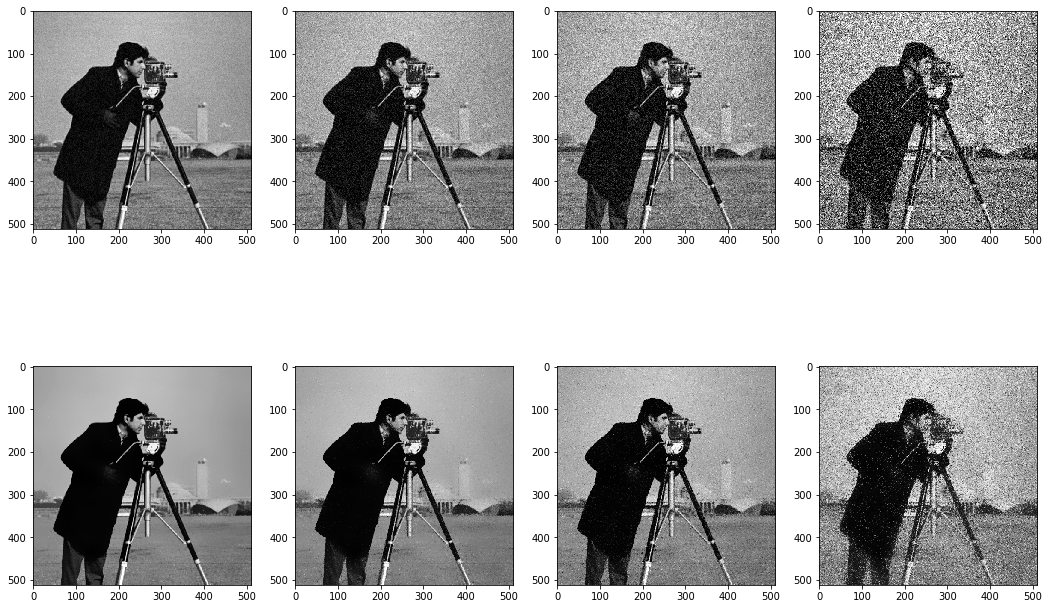

In [13]:
from skimage.filters.rank import mean_bilateral
from skimage.morphology import disk 

noisy1= util.random_noise(im, mode='gaussian', var= 0.001)
filtered1 = mean_bilateral(noisy1, disk(20), s0=30, s1=30)
noisy2= util.random_noise(im, mode='gaussian', var= 0.005)
filtered2 = mean_bilateral(noisy2, disk(20), s0=50, s1=50)
noisy3= util.random_noise(im, mode='gaussian', var= 0.01)
filtered3 = mean_bilateral(noisy3, disk(20), s0=50, s1=50)
#filtered3b = mean_bilateral(filtered3, disk(20), s0=20, s1=20)
noisy4= util.random_noise(im, mode='gaussian', var= 0.05)
filtered4 = mean_bilateral(noisy4, disk(20), s0=100, s1=100)

fig, axes = plt.subplots(ncols=4,nrows=2,figsize=(18,12))
axes[0,0].imshow(noisy1, cmap='gray',interpolation='nearest')
axes[0,1].imshow(noisy2, cmap='gray',interpolation='nearest')
axes[0,2].imshow(noisy3, cmap='gray',interpolation='nearest')
axes[0,3].imshow(noisy4, cmap='gray',interpolation='nearest')
axes[1,0].imshow(filtered1, cmap='gray',interpolation='nearest')
axes[1,1].imshow(filtered2, cmap='gray',interpolation='nearest')
axes[1,2].imshow(filtered3, cmap='gray',interpolation='nearest')
axes[1,3].imshow(filtered4, cmap='gray',interpolation='nearest')
plt.show()

fig.tight_layout()

**Question 8:**
* Les expériences ci-dessus examinent la capacité d'un tel filtre à restaurer une image bruitée avec un bruit gaussien, pour diverses valeurs de bruit et de seuil de "diffère peu" évoqué ci-dessus. Les résultats sont-ils meilleurs que pour le filtrage gaussien ?

**Réponse 8:** Oui le bruit est diminué et l'image est très peu flouté notamment au niveau des contours

## Filtrage median 

On évalue ci-dessous la capacité du filtrage médian à réduire le bruit. Cette évaluation sera faite en terme de qualité d'image perçue et pourra être comparée aux résultats des techniques précédentes.
On peut régler deux paramètres 
* la quantité de bruit
* la taille du disque

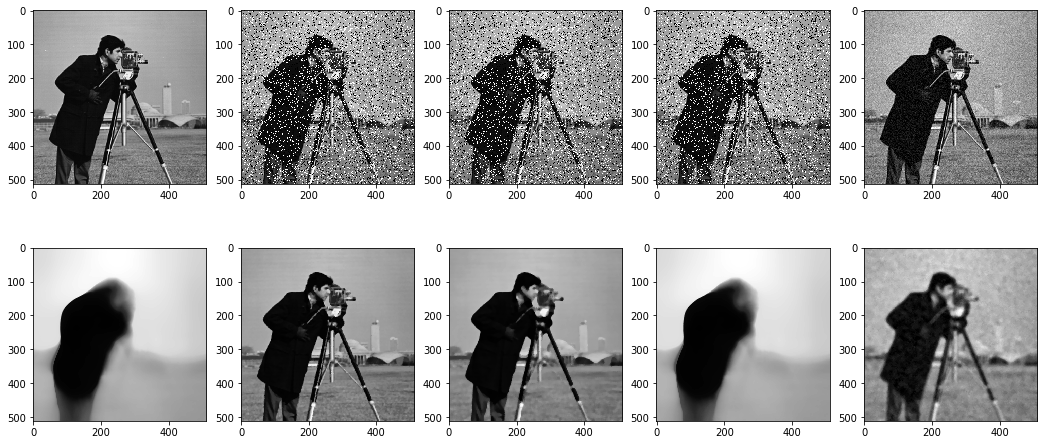

In [32]:
from skimage.filters.rank import median

seuil = 0.1

im = data.camera()

noisy_image=add_salt_and_pepper_noise(im,seuil)
filtered1 = median(im, disk(50))
filtered2 = median(noisy_image, disk(3))
filtered3 = median(noisy_image, disk(5))
filtered4 = median(noisy_image, disk(50))

noisy_gaussian= util.random_noise(im, mode='gaussian', var= 0.003)
filtered_gaussian = median(noisy4, disk(7))

fig, axes = plt.subplots(ncols=5,nrows=2,figsize=(18,8))
axes[0,0].imshow(im, cmap='gray',interpolation='nearest')
axes[0,1].imshow(noisy_image, cmap='gray',interpolation='nearest')
axes[0,2].imshow(noisy_image, cmap='gray',interpolation='nearest')
axes[0,3].imshow(noisy_image, cmap='gray',interpolation='nearest')
axes[0,4].imshow(noisy_gaussian, cmap='gray',interpolation='nearest')
axes[1,0].imshow(filtered1, cmap='gray',interpolation='nearest')
axes[1,1].imshow(filtered2, cmap='gray',interpolation='nearest')
axes[1,2].imshow(filtered3, cmap='gray',interpolation='nearest')
axes[1,3].imshow(filtered4, cmap='gray',interpolation='nearest')
axes[1,4].imshow(filtered_gaussian, cmap='gray',interpolation='nearest')
plt.show()

fig.tight_layout()



**Question 9:** Commentez les performance du filtrage médian pour la réduction de bruit poivre et sel en fonction des différents paramètres que l'on peut faire varier (quantité de bruit, taille du disque). Faites en particulier le lien avec les performances du filtrage gaussien pour ce même type de bruit.


**Réponse 9:** Le bruit est lissé et l'image est très peu flou. Le filtre gaussin lissé le bruit poivre et sel, ici on applique la médianne sur les pixels voisins (valeur de disk), si la valeur de disk est trop grande l'image perd beaucoup d'information, car beaucoup de pixel ont la même valeur, ce qui donne une image avec peu de détails, effet de "tache". Donc la valeur de disk a son importance et doit pas être trop élevé.

## Faire du flou, c'est bien, l'enlever c'est mieux : la déconvolution

Cette section évoque, en l'utilisant comme boite noire, la tâche de déconvolution aveugle. Le code procède comme suit :
* on charge une image contenant du texte (ça pourrait être autre chose !)
* on lui applique du flou (PSF = point spread function), par exemple selon une direction et amplitude que nous choisissons
* on ajoute un peu de bruit
* on cherche alors à récupérer l'image initiale (notez que la déconvolution n'est pas totalement faite à l'aveugle puisqu'on fournit la PSF)

Pas de question sur cet exercice, mais une occasion de constater que la déconvolution n'est pas une tâche triviale dès lors que le signal qu'on traite est bruité (ce qui est toujours le cas dans la "vraie vie" :-))

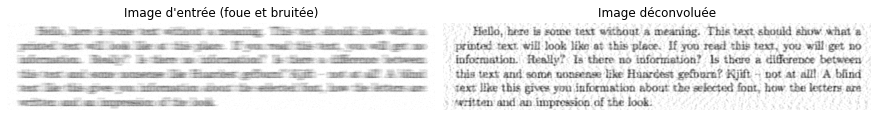

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, data, restoration

image = color.rgb2gray(color.rgba2rgb(io.imread('image-texte.png')))  # Image originale : elle est nette

from scipy.signal import convolve2d as conv2

psf = np.ones((1, 20)) / (1*20) # Vecteur de "mouvement" 

image = conv2(image, psf, 'same', 'symm') # Convolution, qui floute l'image

image += 0.25 * image.std() * np.random.standard_normal(image.shape) #On ajoute un peu de bruit

deconvolved, _ = restoration.unsupervised_wiener(image, psf)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True, subplot_kw={'adjustable':'box'})

plt.gray()

ax[0].imshow(image, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Image d\'entrée (foue et bruitée)')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Image déconvoluée')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)

plt.show()

## Pour en savoir plus.... 

Dans un notebook ipython, on peut également ajouter des widgets pour plus régler directement les paramètres des algorithmes à partir de composants graphiques.

* Diverses librairies comme Bokeh (http://bokeh.pydata.org)
* ou voir par ex. Conference Pydata 2016 : https://www.youtube.com/watch?v=eVET9IYgbao